In [32]:
import pandas as pd
import numpy as np
from itertools import permutations
import seaborn as sns
import string
import math
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.layers import CuDNNLSTM
from keras.layers import LeakyReLU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional
from keras import backend as K
from keras import optimizers
from keras.callbacks import TensorBoard
import tensorflow as tf
plt.style.use("ggplot")

In [3]:
# Food Consumption Score (FCS/FCG).
fcs = pd.read_excel("../ts_fcs.xlsx", index_col = 0, parse_dates = True)
fcs.columns.name = "AdminStrata"

# Reduced Coping Strategy Index (rCSI).
rcsi = pd.read_excel("../ts_rcsi.xlsx", index_col = 0, parse_dates = True)
rcsi.columns.name = "AdminStrata"

# Food Consumption Score (FCS/FCG) + Reduced Coping Strategy Index (rCSI).
fcs_rcsi = pd.concat([fcs.add_prefix("FCS_"), rcsi.add_prefix("rCSI_")], axis = 1)
fcs_rcsi.head()

AdminStrata,FCS_Abyan,FCS_Ad Dali,FCS_Aden,FCS_Al Bayda,FCS_Al Hudaydah,FCS_Al Jawf,FCS_Al Maharah,FCS_Al Mahwit,FCS_Amran,FCS_Dhamar,...,rCSI_Hajjah,rCSI_Ibb,rCSI_Lahj,rCSI_Marib,rCSI_Raymah,rCSI_Sa'dah,rCSI_Sana'a,rCSI_Sana'a City,rCSI_Shabwah,rCSI_Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,95.81,85.11,71.12,92.91,96.81,92.460000,86.89,83.86,69.22,88.64
2015-10-31,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,98.56,85.11,74.81,93.56,90.54,90.851429,89.29,82.34,71.59,89.67
2015-11-30,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,98.21,85.35,73.69,86.93,91.41,89.242857,80.14,79.27,72.87,90.70
2015-12-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,88.17,83.13,84.28,74.33,93.48,87.634286,87.85,80.77,77.00,87.09
2016-01-31,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,93.46,82.33,78.94,74.88,90.61,86.025714,81.97,76.88,80.97,86.21


In [4]:
# Let's define the number of observation we want to predict.
num_predictions = 1
# Let's define the 'train' and 'test' sets.
num_train = len(fcs_rcsi) - num_predictions
fcs_rcsi_train = fcs_rcsi[:num_train]
fcs_rcsi_test = fcs_rcsi[num_train:]
fcs_train = fcs[:num_train]
fcs_test = fcs[num_train:]
print("The number of points used to forecast is:", len(fcs_rcsi_train))
print("The number of points to use for testing the forecast is:", len(fcs_rcsi_test))

The number of points used to forecast is: 48
The number of points to use for testing the forecast is: 1


In [5]:
dates_to_forecast = fcs_rcsi_test.index
dates_to_forecast.array

<DatetimeArray>
['2019-09-30 00:00:00']
Length: 1, dtype: datetime64[ns]

(42.0, 0.0)

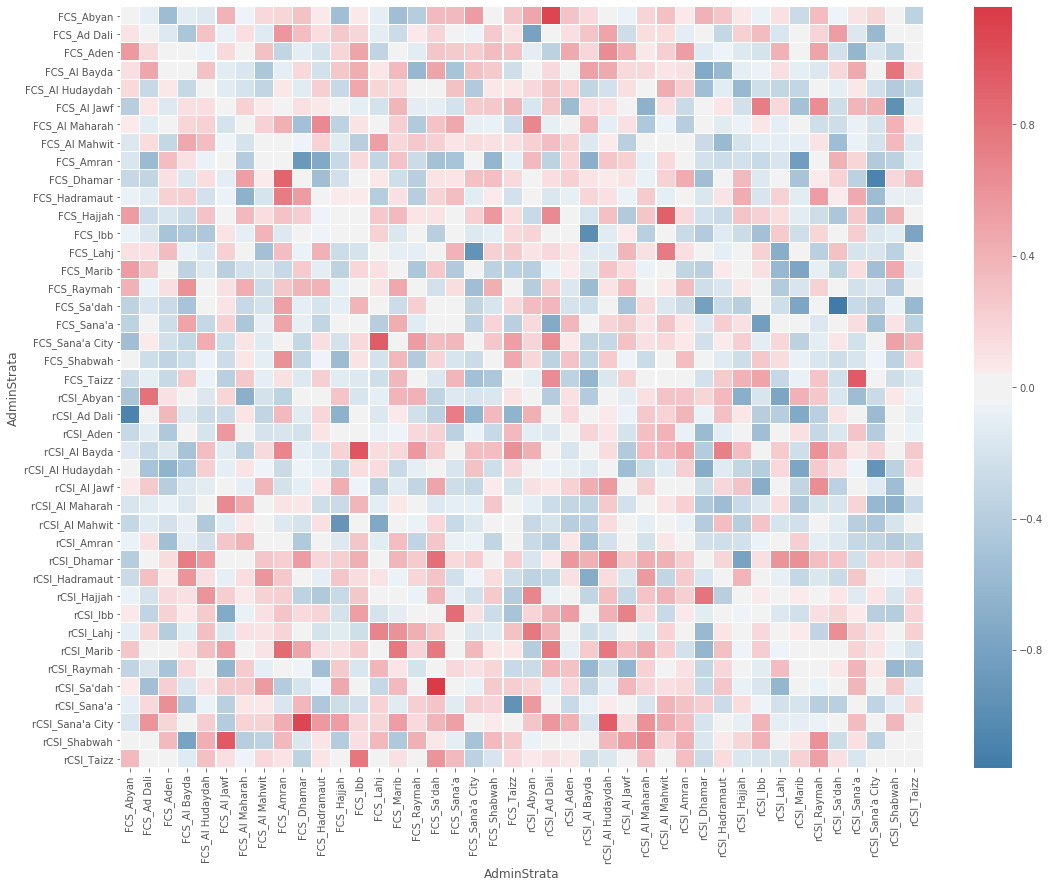

In [6]:
# Analysis paper "The dynamics of information-driven coordination phenomena: A transfer entropy analysis".

# Embedding dimension with which obtain symbol series: 3 <= m <= 7.
m = 3

# Get the pattern to permutate based on the value m.
pattern = np.arange(m) + 1
# Get all permutations/patterns.
patterns = list(permutations(pattern))
# Get a list of indices linked to symbols (alphabet) corresponding to each pattern.
symbols = list(string.ascii_uppercase)
dict_pattern_symbol = dict()
for i in range(len(patterns)):
    dict_pattern_symbol[patterns[i]] = symbols[i]

dict_pattern_index = dict()
for i in range(len(patterns)):
    dict_pattern_index[patterns[i]] = i
    
def symbolized_sample(pattern):
    sorted_indices = tuple(np.argsort(pattern) + 1)
    symbol = dict_pattern_index[sorted_indices]
    return symbol
    
ts_symb = fcs_rcsi_train.rolling(m).apply(symbolized_sample, raw = True).dropna().reset_index(drop = True)

def STE_XY(X, Y):
    N = len(X)
    T_XY = 0
    for i in range(N - 1):
        yi = (Y == Y[i]).astype(int)
        yip1 = np.roll((Y == Y[i + 1]).astype(int), -1) # Shift one forward.
        xi = (X == X[i]).astype(int)
        
        prob1 = (yi + yip1 + xi == 3).astype(int)[0:N].sum()/(N)
        prob2 = ((yi + yip1 + xi == 3).astype(int)[0:N].sum()/(N)) / ((yi + xi == 2).astype(int)[0:N].sum()/(N))
        prob3 = ((yi + yip1 == 2).astype(int)[0:N].sum()/(N)) / (yi[0:N].sum()/(N)) 
        
        T_XY += prob1 * math.log2(prob2 / prob3)
        
    return T_XY

T = np.tril(ts_symb.corr(method = STE_XY).values) + np.triu(ts_symb.corr(method = lambda *args : STE_XY(*args[::-1])).values)
np.fill_diagonal(T, ts_symb.apply(lambda x: STE_XY(x, x)))
T = pd.DataFrame(T, index = ts_symb.columns, columns = ts_symb.columns)

T_s = (T.values.transpose() - T.values).transpose()
T_s = pd.DataFrame(T_s, index = ts_symb.columns, columns = ts_symb.columns)

fig = plt.figure(figsize = (18, 14))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(T_s, linewidths = .1, cmap = cmap, center = 0, xticklabels = T_s.columns, yticklabels = T_s.columns)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [7]:
# Split a multivariate sequence into samples.
n_steps = 3

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [30]:
X_tot = list()
y_tot = list()
for AdminStrata in fcs_train.columns:
    # Example for multivariate analysis.
    min_ = 0
    for key in T_s["FCS_" + AdminStrata].keys():
        if "rCSI" in key and T_s["FCS_" + AdminStrata][key] < min_:
            min_ = T_s["FCS_" + AdminStrata][key]
            corr_feature_name = key
    rcsi_fcs_pairwise = fcs_rcsi_train[[corr_feature_name, "FCS_" + AdminStrata]]
    X, y = split_sequences(rcsi_fcs_pairwise.values, n_steps)
    X_tot.append(X)
    y_tot.append(y)
    
X_tot = np.concatenate(X_tot)
y_tot = np.concatenate(y_tot)

In [31]:
X_test = list()
y_test = list()
for AdminStrata in fcs_train.columns:
    # Example for multivariate analysis.
    min_ = 0
    for key in T_s["FCS_" + AdminStrata].keys():
        if "rCSI" in key and T_s["FCS_" + AdminStrata][key] < min_:
            min_ = T_s["FCS_" + AdminStrata][key]
            corr_feature_name = key
    X = fcs_rcsi_train[[corr_feature_name, "FCS_" + AdminStrata]][-n_steps:].values
    y = fcs_test[AdminStrata].values
    X_test.append([X])
    y_test.append(y)
    
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [33]:
if tf.gfile.Exists("./logs"): 
    tf.gfile.DeleteRecursively("./logs") 
    
units = 128
num_epochs = 1000
learning_rate = 0.006

n_features = X_tot.shape[2]
# Define model and perform a preliminary training with all data.
model = Sequential()
model.add(CuDNNLSTM(units, return_sequences = True, input_shape = (n_steps, n_features)))
model.add(LeakyReLU(alpha = 0.3))
model.add(CuDNNLSTM(units))
model.add(LeakyReLU(alpha = 0.3))
#model.add(Dropout(0.1))
model.add(Dense(1))
algorithm = optimizers.Adam(lr = learning_rate, decay = 0.07)

# Define the checkpoint.
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_loss", verbose = 0, save_best_only = True, mode = "min")
# Save results in the tensorboard.
callbacks_list = [checkpoint]

model.compile(optimizer = algorithm, loss = "mse")

# Fit model.
history = model.fit(X_tot, y_tot, epochs = num_epochs, verbose = 2, validation_data = (X_test, y_test), batch_size = 32, callbacks = callbacks_list)

Train on 945 samples, validate on 21 samples
Epoch 1/1000
 - 3s - loss: 1359.5510 - val_loss: 614.6882
Epoch 2/1000
 - 0s - loss: 913.0941 - val_loss: 453.3368
Epoch 3/1000
 - 0s - loss: 766.6398 - val_loss: 371.1052
Epoch 4/1000
 - 0s - loss: 681.1204 - val_loss: 318.7938
Epoch 5/1000
 - 0s - loss: 623.1679 - val_loss: 281.8142
Epoch 6/1000
 - 0s - loss: 580.1200 - val_loss: 253.7437
Epoch 7/1000
 - 0s - loss: 546.2158 - val_loss: 232.2515
Epoch 8/1000
 - 0s - loss: 519.1417 - val_loss: 214.6416
Epoch 9/1000
 - 0s - loss: 496.5222 - val_loss: 200.3571
Epoch 10/1000
 - 0s - loss: 477.4352 - val_loss: 188.1504
Epoch 11/1000
 - 0s - loss: 460.8205 - val_loss: 177.9113
Epoch 12/1000
 - 0s - loss: 446.5924 - val_loss: 168.7861
Epoch 13/1000
 - 0s - loss: 433.8140 - val_loss: 160.8923
Epoch 14/1000
 - 0s - loss: 422.3618 - val_loss: 154.2155
Epoch 15/1000
 - 0s - loss: 412.3380 - val_loss: 147.9129
Epoch 16/1000
 - 0s - loss: 403.0218 - val_loss: 142.4702
Epoch 17/1000
 - 0s - loss: 394.744

Epoch 143/1000
 - 0s - loss: 149.8936 - val_loss: 29.3800
Epoch 144/1000
 - 0s - loss: 149.3933 - val_loss: 29.4666
Epoch 145/1000
 - 0s - loss: 148.9082 - val_loss: 29.7169
Epoch 146/1000
 - 0s - loss: 148.3706 - val_loss: 29.4056
Epoch 147/1000
 - 0s - loss: 147.8654 - val_loss: 29.4651
Epoch 148/1000
 - 0s - loss: 147.3787 - val_loss: 29.5755
Epoch 149/1000
 - 0s - loss: 146.9130 - val_loss: 29.0855
Epoch 150/1000
 - 0s - loss: 146.4228 - val_loss: 29.4606
Epoch 151/1000
 - 0s - loss: 145.9995 - val_loss: 29.7868
Epoch 152/1000
 - 0s - loss: 145.5012 - val_loss: 28.7171
Epoch 153/1000
 - 0s - loss: 145.0162 - val_loss: 28.4721
Epoch 154/1000
 - 0s - loss: 144.5371 - val_loss: 28.9075
Epoch 155/1000
 - 0s - loss: 144.0727 - val_loss: 28.7972
Epoch 156/1000
 - 0s - loss: 143.6335 - val_loss: 28.8373
Epoch 157/1000
 - 0s - loss: 143.1601 - val_loss: 28.8028
Epoch 158/1000
 - 0s - loss: 142.7238 - val_loss: 28.2386
Epoch 159/1000
 - 0s - loss: 142.2950 - val_loss: 28.5849
Epoch 160/1000

 - 0s - loss: 107.8122 - val_loss: 24.9069
Epoch 285/1000
 - 0s - loss: 107.6384 - val_loss: 24.8833
Epoch 286/1000
 - 0s - loss: 107.4542 - val_loss: 25.3329
Epoch 287/1000
 - 0s - loss: 107.2933 - val_loss: 25.3649
Epoch 288/1000
 - 0s - loss: 107.1330 - val_loss: 25.0019
Epoch 289/1000
 - 0s - loss: 106.9445 - val_loss: 25.2094
Epoch 290/1000
 - 0s - loss: 106.7864 - val_loss: 25.4932
Epoch 291/1000
 - 0s - loss: 106.6156 - val_loss: 25.0673
Epoch 292/1000
 - 0s - loss: 106.4574 - val_loss: 24.9376
Epoch 293/1000
 - 0s - loss: 106.2872 - val_loss: 25.0424
Epoch 294/1000
 - 0s - loss: 106.1346 - val_loss: 25.2894
Epoch 295/1000
 - 0s - loss: 105.9982 - val_loss: 25.2299
Epoch 296/1000
 - 0s - loss: 105.8004 - val_loss: 25.5635
Epoch 297/1000
 - 0s - loss: 105.6388 - val_loss: 25.3926
Epoch 298/1000
 - 0s - loss: 105.4804 - val_loss: 25.0730
Epoch 299/1000
 - 0s - loss: 105.2989 - val_loss: 25.1721
Epoch 300/1000
 - 0s - loss: 105.1744 - val_loss: 25.7086
Epoch 301/1000
 - 0s - loss: 

 - 0s - loss: 90.2891 - val_loss: 25.9404
Epoch 428/1000
 - 0s - loss: 90.2056 - val_loss: 26.0956
Epoch 429/1000
 - 0s - loss: 90.1263 - val_loss: 26.3030
Epoch 430/1000
 - 0s - loss: 90.0338 - val_loss: 26.3074
Epoch 431/1000
 - 0s - loss: 89.9491 - val_loss: 26.2039
Epoch 432/1000
 - 0s - loss: 89.8854 - val_loss: 26.4326
Epoch 433/1000
 - 0s - loss: 89.7922 - val_loss: 26.0518
Epoch 434/1000
 - 0s - loss: 89.7172 - val_loss: 25.8565
Epoch 435/1000
 - 0s - loss: 89.6130 - val_loss: 26.3394
Epoch 436/1000
 - 0s - loss: 89.5491 - val_loss: 26.1968
Epoch 437/1000
 - 0s - loss: 89.4588 - val_loss: 26.3578
Epoch 438/1000
 - 0s - loss: 89.4013 - val_loss: 26.7005
Epoch 439/1000
 - 0s - loss: 89.3030 - val_loss: 26.0845
Epoch 440/1000
 - 0s - loss: 89.2136 - val_loss: 26.2585
Epoch 441/1000
 - 0s - loss: 89.1293 - val_loss: 26.3340
Epoch 442/1000
 - 0s - loss: 89.0493 - val_loss: 26.3565
Epoch 443/1000
 - 0s - loss: 88.9748 - val_loss: 25.8338
Epoch 444/1000
 - 0s - loss: 88.9147 - val_los

Epoch 571/1000
 - 0s - loss: 80.9400 - val_loss: 26.5391
Epoch 572/1000
 - 0s - loss: 80.8870 - val_loss: 26.0868
Epoch 573/1000
 - 0s - loss: 80.8474 - val_loss: 26.5400
Epoch 574/1000
 - 0s - loss: 80.7742 - val_loss: 26.2219
Epoch 575/1000
 - 0s - loss: 80.7300 - val_loss: 26.3432
Epoch 576/1000
 - 0s - loss: 80.6817 - val_loss: 26.1009
Epoch 577/1000
 - 0s - loss: 80.6338 - val_loss: 26.1360
Epoch 578/1000
 - 0s - loss: 80.5806 - val_loss: 26.1092
Epoch 579/1000
 - 0s - loss: 80.5340 - val_loss: 26.0408
Epoch 580/1000
 - 0s - loss: 80.4927 - val_loss: 26.0472
Epoch 581/1000
 - 0s - loss: 80.4400 - val_loss: 25.9123
Epoch 582/1000
 - 0s - loss: 80.3905 - val_loss: 26.1322
Epoch 583/1000
 - 0s - loss: 80.3505 - val_loss: 26.3189
Epoch 584/1000
 - 0s - loss: 80.2943 - val_loss: 26.1683
Epoch 585/1000
 - 0s - loss: 80.2671 - val_loss: 25.9394
Epoch 586/1000
 - 0s - loss: 80.2071 - val_loss: 26.2038
Epoch 587/1000
 - 0s - loss: 80.1869 - val_loss: 25.7573
Epoch 588/1000
 - 0s - loss: 80

Epoch 715/1000
 - 0s - loss: 75.3128 - val_loss: 25.9744
Epoch 716/1000
 - 0s - loss: 75.2841 - val_loss: 25.8301
Epoch 717/1000
 - 0s - loss: 75.2468 - val_loss: 25.7801
Epoch 718/1000
 - 0s - loss: 75.2231 - val_loss: 25.7534
Epoch 719/1000
 - 0s - loss: 75.1935 - val_loss: 25.9543
Epoch 720/1000
 - 0s - loss: 75.1547 - val_loss: 25.9190
Epoch 721/1000
 - 0s - loss: 75.1479 - val_loss: 25.7898
Epoch 722/1000
 - 0s - loss: 75.1074 - val_loss: 26.1467
Epoch 723/1000
 - 0s - loss: 75.0752 - val_loss: 25.9766
Epoch 724/1000
 - 0s - loss: 75.0364 - val_loss: 25.8753
Epoch 725/1000
 - 0s - loss: 75.0158 - val_loss: 25.9239
Epoch 726/1000
 - 0s - loss: 74.9750 - val_loss: 26.0693
Epoch 727/1000
 - 0s - loss: 74.9456 - val_loss: 26.0881
Epoch 728/1000
 - 0s - loss: 74.9200 - val_loss: 26.1760
Epoch 729/1000
 - 0s - loss: 74.8918 - val_loss: 26.1940
Epoch 730/1000
 - 0s - loss: 74.8552 - val_loss: 26.2488
Epoch 731/1000
 - 0s - loss: 74.8244 - val_loss: 26.2207
Epoch 732/1000
 - 0s - loss: 74

Epoch 859/1000
 - 0s - loss: 71.6843 - val_loss: 26.0978
Epoch 860/1000
 - 0s - loss: 71.6680 - val_loss: 26.0199
Epoch 861/1000
 - 0s - loss: 71.6455 - val_loss: 25.9898
Epoch 862/1000
 - 0s - loss: 71.6439 - val_loss: 26.0964
Epoch 863/1000
 - 0s - loss: 71.6082 - val_loss: 25.9582
Epoch 864/1000
 - 0s - loss: 71.5839 - val_loss: 26.0405
Epoch 865/1000
 - 0s - loss: 71.5799 - val_loss: 26.2164
Epoch 866/1000
 - 0s - loss: 71.5783 - val_loss: 25.8464
Epoch 867/1000
 - 0s - loss: 71.5293 - val_loss: 26.1545
Epoch 868/1000
 - 0s - loss: 71.5115 - val_loss: 25.9312
Epoch 869/1000
 - 0s - loss: 71.5096 - val_loss: 26.2604
Epoch 870/1000
 - 0s - loss: 71.4646 - val_loss: 26.0363
Epoch 871/1000
 - 0s - loss: 71.4500 - val_loss: 26.0911
Epoch 872/1000
 - 0s - loss: 71.4272 - val_loss: 26.0655
Epoch 873/1000
 - 0s - loss: 71.4085 - val_loss: 26.0135
Epoch 874/1000
 - 0s - loss: 71.3995 - val_loss: 26.0626
Epoch 875/1000
 - 0s - loss: 71.3660 - val_loss: 26.1397
Epoch 876/1000
 - 0s - loss: 71

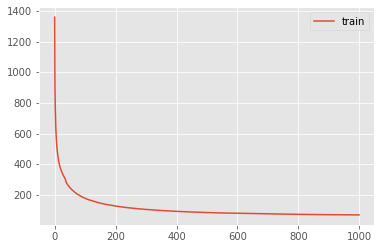

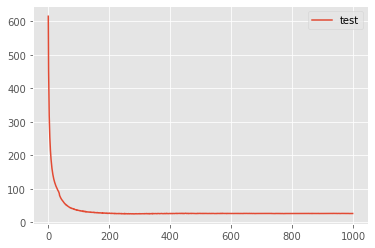

In [34]:
# Plot history.
plt.plot(history.history["loss"], label = "train")
plt.legend()
plt.show()

plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()

In [35]:
def one_step_prediction(ts):
    #X, y = split_sequences(fcs_rcsi[["rCSI_" + ts.name, "FCS_" + ts.name]].values, n_steps)
    # Load the model.
    K.clear_session()
    print(ts.name)
    new_model = load_model("model.h5")
    #algorithm = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01, amsgrad = False)
    #new_model.compile(optimizer = algorithm, loss = "mse")
    #new_model.fit(X, y, epochs = 10, verbose = 0, batch_size = 32)
    # Demonstrate prediction.
    min_ = 0
    for key in T_s["FCS_" + AdminStrata].keys():
        if "rCSI" in key and T_s["FCS_" + AdminStrata][key] < min_:
            min_ = T_s["FCS_" + AdminStrata][key]
            corr_feature_name = key
    x_input = fcs_rcsi[[corr_feature_name, "FCS_" + ts.name]].values[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = new_model.predict(x_input, verbose = 0).flatten()
    yhat = pd.Series(yhat, index = [dates_to_forecast[0]], name = ts.name)
    return yhat

In [36]:
yhats = fcs_train.apply(one_step_prediction)

Abyan
Abyan
Ad Dali
Aden
Al Bayda
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amran
Dhamar
Hadramaut
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'dah
Sana'a
Sana'a City
Shabwah
Taizz


In [37]:
fcs_test

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-30,35.85,45.43,28.92,46.15,30.97,51.31,15.28,34.58,33.21,40.5,...,38.73,48.89,46.17,39.13,54.87,40.56,40.76,32.1,44.9,40.31


In [38]:
yhats

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
2019-09-30,37.373596,43.356808,30.340315,43.394863,31.266205,45.856289,18.466782,33.955826,33.043941,41.198349,...,38.906898,44.94236,44.54068,37.845802,45.634216,38.75116,39.684563,32.524929,43.502884,39.610168


In [41]:
def error(ts):
    error = np.sqrt(mean_squared_error(y_true = ts, 
                                       y_pred = yhats[ts.name]))
    return error

In [42]:
fcs_test.apply(error).mean()

1.968559661138627

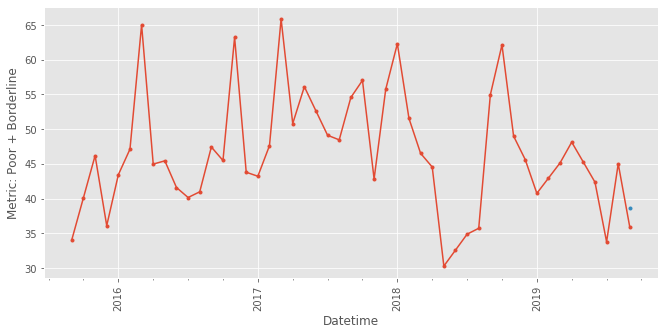

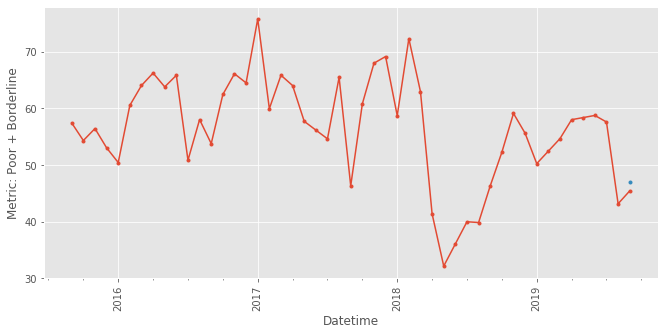

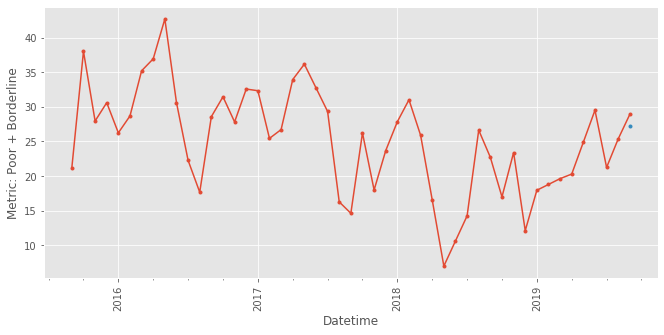

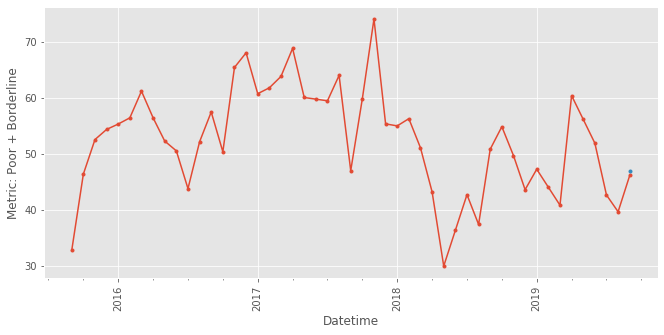

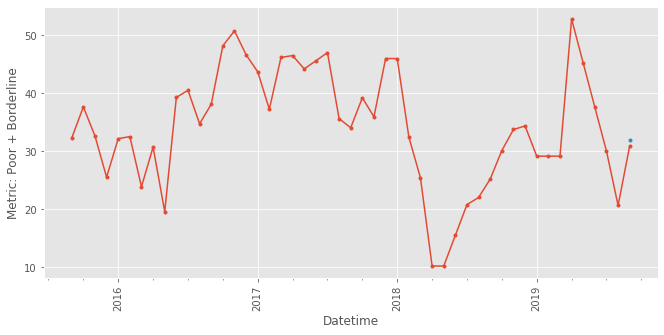

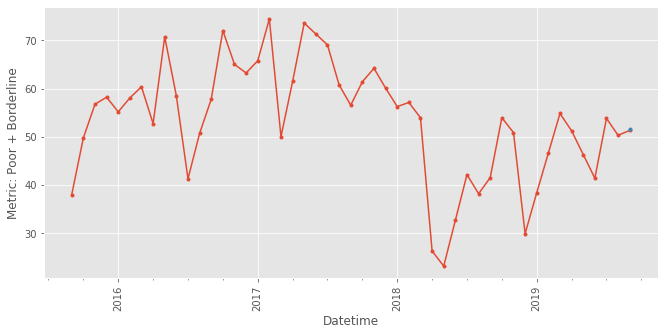

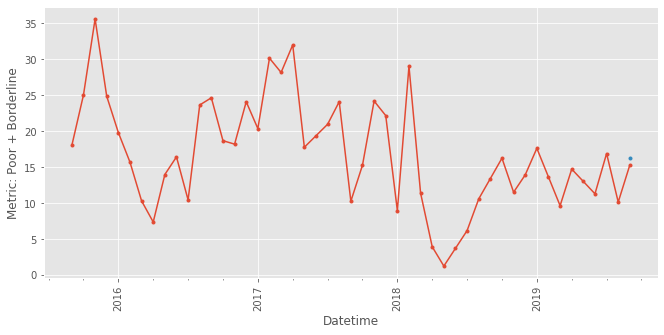

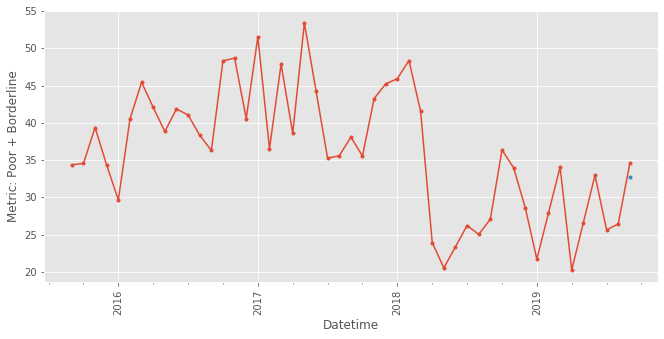

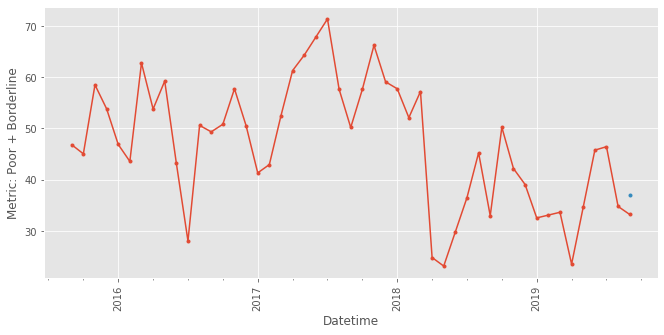

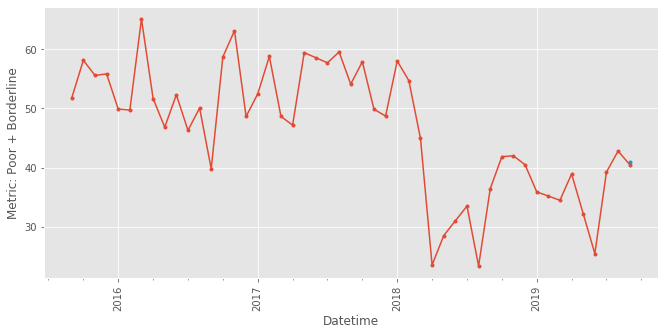

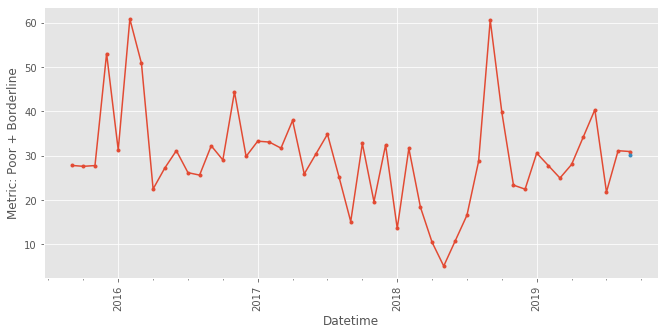

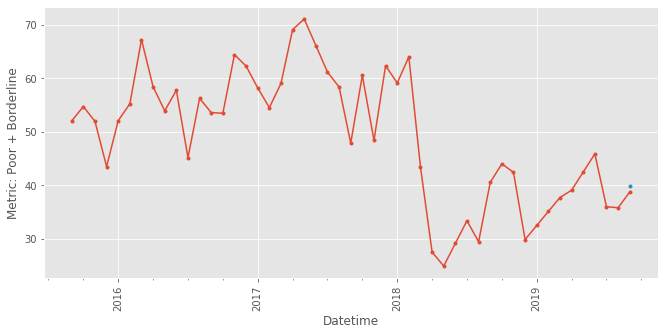

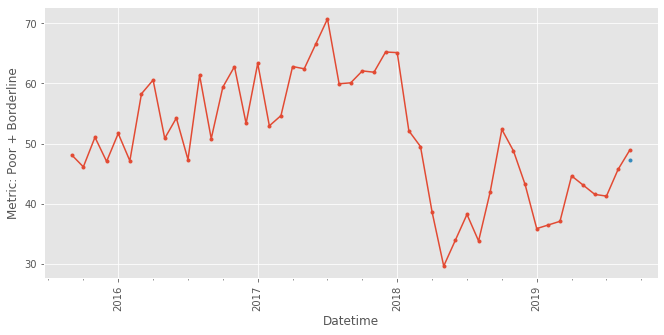

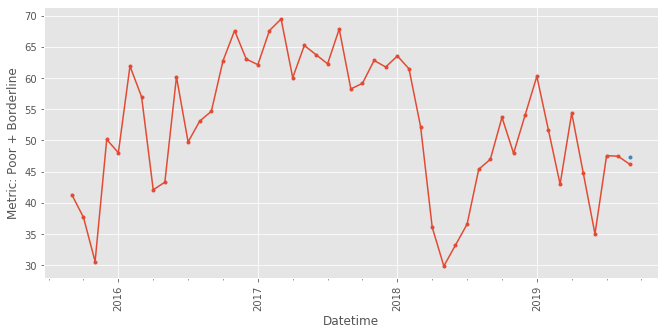

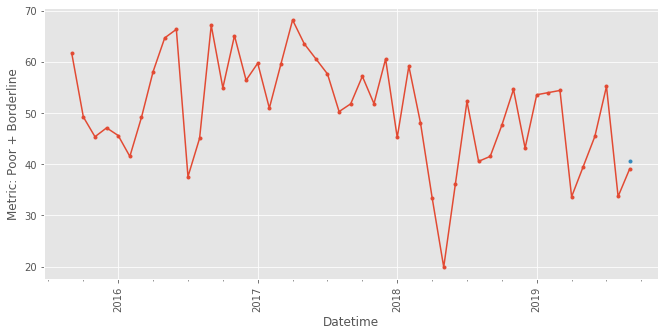

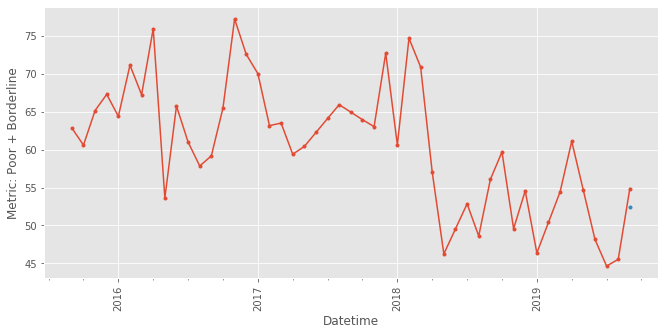

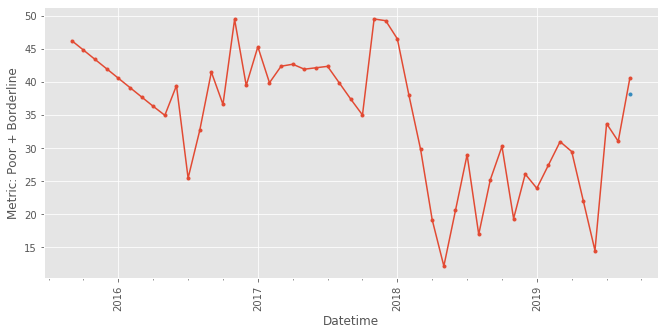

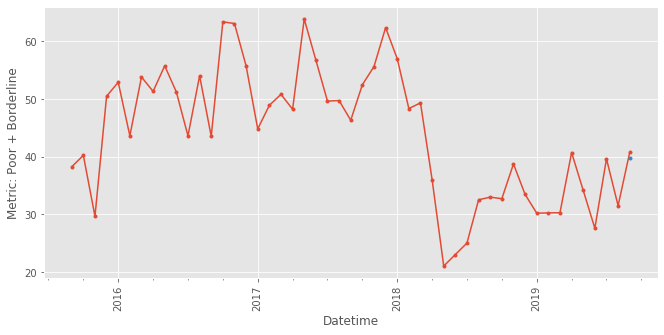

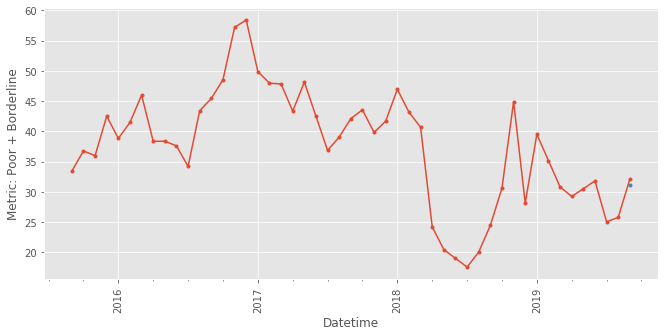

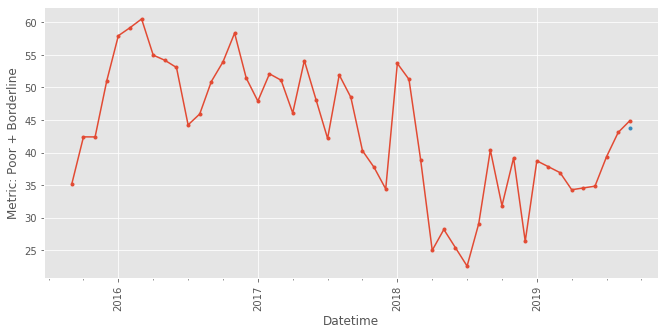

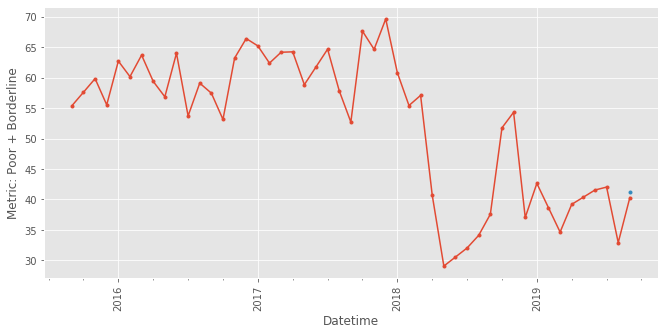

In [52]:
for AdminStrata in fcs_train.columns:
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    fcs[AdminStrata].plot(ax = fig.gca(), style = ".-")
    yhats[AdminStrata].plot(ax = fig.gca(), style = ".-")
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [17]:
b=T_s["FCS_" + "Sana'a City"]
b

AdminStrata
FCS_Abyan           0.537238
FCS_Ad Dali        -0.047026
FCS_Aden            0.232613
FCS_Al Bayda        0.309368
FCS_Al Hudaydah    -0.428055
FCS_Al Jawf         0.242650
FCS_Al Maharah     -0.086550
FCS_Al Mahwit       0.142497
FCS_Amran          -0.007123
FCS_Dhamar          0.313984
FCS_Hadramaut      -0.122096
FCS_Hajjah          0.215506
FCS_Ibb            -0.151666
FCS_Lahj           -0.938254
FCS_Marib          -0.018030
FCS_Raymah         -0.541313
FCS_Sa'dah         -0.332680
FCS_Sana'a         -0.369046
FCS_Sana'a City     0.000000
FCS_Shabwah        -0.269846
FCS_Taizz          -0.518416
rCSI_Abyan         -0.188450
rCSI_Ad Dali       -0.633381
rCSI_Aden          -0.055799
rCSI_Al Bayda       0.332072
rCSI_Al Hudaydah    0.300655
rCSI_Al Jawf       -0.303944
rCSI_Al Maharah    -0.101423
rCSI_Al Mahwit     -0.157502
rCSI_Amran         -0.057044
rCSI_Dhamar         0.235141
rCSI_Hadramaut     -0.045306
rCSI_Hajjah        -0.219163
rCSI_Ibb            0.108756
rC

In [29]:
name

'rCSI_Ad Dali'

In [27]:
"FCS" in "FCS_Abyan" 

True